In [124]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cftime
import dask
import xarrayutils
import cartopy.crs as ccrs
from xmip.preprocessing import combined_preprocessing
from xmip.preprocessing import replace_x_y_nominal_lat_lon
from xmip.drift_removal import replace_time
from xmip.postprocessing import concat_experiments
import xmip.drift_removal as xm_dr
import xmip as xm
import xesmf as xe
import datetime
from dateutil.relativedelta import relativedelta
import utils
import scipy.signal as signal
import cf_xarray as cfxr
from datetime import timedelta


dask.config.set(**{'array.slicing.split_large_chunks': True})


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Notes:

GFDL: A1B1 and esm pi-control start from year 0001

UKESM1: A1B1 starts in 1850 and pi-control starts in 1960, move A1B1 to start in 1960

MIROC: both start from 1850

NORESM2: A1B1 from 0001 pi-control from 1600-- move A1B1 to 1600

ACCESS: A1B1 and pi-control from 0101

CANESM5_r1p1: A1B1 1850, pi-control 5201, move A1B1 to 5201

CANESM5_r1p2: A1B1 1850, pi-control 5550, move A1B1 to 5550


## Import data and calculate GF

In [125]:
model_run_A1B1_dict = utils.model_run_A1_B1_dict
model_run_control_dict = utils.model_run_picontrol_dict


In [126]:
model_run_A1B1_dict

{'GFDL_B1': 'GFDL-ESM2M_esm-bell-1000PgC_1861_2360.csv',
 'NORESM2_B1': 'NorESM2-LM_esm-bell-1000PgC_1850-2049.csv',
 'GFDL_A1': 'GFDL-ESM2M_esm-1pct-brch-1000PgC_1861_2360.csv',
 'NORESM2_A1': 'NorESM2-LM_esm-1pct-brch-1000PgC_0066-0167.csv'}

In [127]:
fg_co2_A1B1 = {}
fg_co2_pictrl = {}
nbp_A1B1 = {}
nbp_pictrl = {}
co2_A1B1 = {}
co2_pictrl = {}
areacello = {}
areacella = {}

In [128]:
for m in model_run_A1B1_dict.keys():
    print(m)
    print('load A1B1 run')

    fg_co2_A1B1[m] = pd.read_csv(f'zecmip_data/fgco2_{model_run_A1B1_dict[m]}', names = ['year','val']) #kgC/m2/s

    nbp_A1B1[m] = pd.read_csv(f'zecmip_data/nbp_{model_run_A1B1_dict[m]}', names = ['year','val']) #kgC/m2/s
    co2_A1B1[m] = pd.read_csv(f'zecmip_data/co2_{model_run_A1B1_dict[m]}', names = ['year','val']) #kg
    
    

GFDL_B1
load A1B1 run
NORESM2_B1
load A1B1 run
GFDL_A1
load A1B1 run
NORESM2_A1
load A1B1 run


In [129]:
for m in model_run_A1B1_dict.keys():
    fg_co2_A1B1[m]['val']*=1e12
    nbp_A1B1[m]['val']*=1e12

In [130]:
for m in ['NORESM2','GFDL']:
    print(m)
    print('load pi control run')
    fg_co2_pictrl[m] = xr.open_mfdataset(f'cmip6_data/fgco2_Omon_{model_run_control_dict[m]}', use_cftime=True, engine = 'netcdf4') #kg/m2/s 
    
    nbp_pictrl[m] = xr.open_mfdataset(f'cmip6_data/nbp_Lmon_{model_run_control_dict[m]}',use_cftime=True, engine = 'netcdf4') #kgC/m2/s 

    if m == 'NORESM2' or m == 'GFDL':
        co2_pictrl[m] = xr.open_mfdataset(f'cmip6_data/co2mass_Amon_{model_run_control_dict[m]}',use_cftime=True, engine = 'netcdf4') #kg
    
    areacello[m] = xr.open_mfdataset(f'cmip6_data/areacello_Ofx_{model_run_control_dict[m]}', use_cftime=True, engine = 'netcdf4')
    areacella[m] = xr.open_mfdataset(f'cmip6_data/areacella_fx_{model_run_control_dict[m]}', use_cftime=True, engine = 'netcdf4')


NORESM2
load pi control run
GFDL
load pi control run


In [131]:
 
kgCO2_to_kgC = 1/3.67

In [132]:
for m in co2_A1B1.keys():
    co2_A1B1[m]['val']*=7.821e12 #convert to kg
    co2_A1B1[m]['G_atm'] = co2_A1B1[m]['val'].diff() #kg/year
    co2_A1B1[m]['G_atm']#*=kgCO2_to_kgC #kgC/year

In [133]:
for m in ['NORESM2', 'GFDL']: 
    seconds_per_yr = 60*60*24*365
    co2_pictrl[m]['G_atm'] = co2_pictrl[m]['co2mass'].diff('time')/(co2_pictrl[m]['time'].diff('time').astype('float64')/(1e9*seconds_per_yr)) #convert from ns to year via 1e9ns/s x 60s/min x 60min/hr x 24hr/day x 365day/yr
    co2_pictrl[m]['G_atm'] *= kgCO2_to_kgC
    co2_pictrl[m]['G_atm'].attrs = {'units':'kgC'}

## fix the times so that they line up according to the notes above
m = 'NORESM2'
nbp_pictrl[m]['time'] = nbp_pictrl[m]['time'] -timedelta(365*1599)
fg_co2_pictrl[m]['time'] = fg_co2_pictrl[m]['time'] - timedelta(365*1599)
co2_pictrl[m]['time'] = co2_pictrl[m]['time'] - timedelta(365*1599)
co2_A1B1[m] *=1.5172413793 #currently saved as the vmr (see the attributes, has not been properly converted)
co2_pictrl[m] *=1.5172413793 #currently saved as the vmr (see the attributes, has not been properly converted)


m = 'UKESM1_r1'
nbp_pictrl[m]['time'] = nbp_pictrl['UKESM1_r1']['time'] - timedelta(360*110)
fg_co2_pictrl[m]['time'] = fg_co2_pictrl['UKESM1_r1']['time'] - timedelta(360*110)
co2_pictrl[m]['time'] = co2_pictrl['UKESM1_r1']['time'] - timedelta(360*110)

m = 'CANESM5_r1p2'
nbp_pictrl[m]['time'] = nbp_pictrl['CANESM5_r1p2']['time']- timedelta(365*3700)
fg_co2_pictrl[m]['time'] = fg_co2_pictrl['CANESM5_r1p2']['time']- timedelta(365*3700)

m = 'CANESM5_r1p1'
nbp_pictrl[m]['time'] = nbp_pictrl['CANESM5_r1p1']['time']- timedelta(365*3351)
fg_co2_pictrl[m]['time'] = fg_co2_pictrl['CANESM5_r1p1']['time']- timedelta(365*3351)


In [134]:
#define our output grid size

ds_out = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-89.5, 90.5, 1.0)),
        "lon": (["lon"], np.arange(0.5, 360.5, 1)),
        "lat_b": (["lat_b"], np.arange(-90.,91.,1.0)),
        "lon_b":(["lon_b"], np.arange(0, 361, 1.0))
    }
)
A = utils.find_area(ds_out, R = 6.3781e6)

#replace GFDL areacello with this-- areacello doesn't match up

areacello['GFDL'] = A

In [135]:
fg_co2 = {}
nbp = {}

for m1 in ['GFDL','NORESM2']:
    m2 = m1
    print(m1, m2)
    if m2 == 'GFDL':
        fg_co2_pictrl[m1]['fgco2'] = fg_co2_pictrl[m1]['fgco2']*seconds_per_yr*areacello[m2]
    else:
        fg_co2_pictrl[m1]['fgco2'] = fg_co2_pictrl[m1]['fgco2']*seconds_per_yr*areacello[m2]['areacello']
    nbp_pictrl[m1]['nbp'] = nbp_pictrl[m1]['nbp']*seconds_per_yr*areacella[m2]['areacella']

GFDL GFDL
NORESM2 NORESM2


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/dask/array/core.py:4697: PerformanceWarning: Increasing number of chunks by factor of 25
  result = blockwise(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/dask/array/core.py:4697: PerformanceWarning: Increasing number of chunks by factor of 25
  result = blockwise(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/dask/array/core.py:4697: PerformanceWarning: Increasing number of chunks by factor of 21
  result = blockwise(


In [136]:
#total sinks
nbp_tot = {}
fg_co2_tot = {}
for m in nbp_pictrl.keys():
    if 'lat' in list(fg_co2_pictrl[m]['fgco2'].dims):
        nbp_tot[m] = nbp_pictrl[m]['nbp'].sum(dim = ['lat','lon'])
        fg_co2_tot[m] = fg_co2_pictrl[m]['fgco2'].sum(dim = ['lat','lon'])
    elif 'i' in list(fg_co2_pictrl[m]['fgco2'].dims):
        nbp_tot[m] = nbp_pictrl[m]['nbp'].sum(dim = ['lat','lon'])
        fg_co2_tot[m] = fg_co2_pictrl[m]['fgco2'].sum(dim = ['i','j'])
    elif 'x' in list(fg_co2_pictrl[m]['fgco2'].dims):
        nbp_tot[m] = nbp_pictrl[m]['nbp'].sum(dim = ['lat','lon'])
        fg_co2_tot[m] = fg_co2_pictrl[m]['fgco2'].sum(dim = ['x','y'])

In [137]:
#fix the times to all be the same, weight by month and take the mean

for m in nbp_tot.keys():  
    print(m)
    times = nbp_tot[m].time.get_index('time')
    weights = times.shift(-1, 'MS') - times.shift(1, 'MS')
    weights = xr.DataArray(weights, [('time', nbp_tot[m]['time'].values)]).astype('float')
    nbp_tot[m] =  (nbp_tot[m] * weights).groupby('time.year').sum('time')/weights.groupby('time.year').sum('time')
    fg_co2_tot[m] =  (fg_co2_tot[m] * weights).groupby('time.year').sum('time')/weights.groupby('time.year').sum('time')

NORESM2
GFDL


In [138]:
for m in co2_pictrl.keys():    
    times = co2_pictrl[m].time.get_index('time')
    weights = times.shift(-1, 'MS') - times.shift(1, 'MS')
    weights = xr.DataArray(weights, [('time', co2_pictrl[m]['time'].values)]).astype('float')
    co2_pictrl[m] =  (co2_pictrl[m] * weights).groupby('time.year').sum('time')/weights.groupby('time.year').sum('time')

In [139]:
fg_co2_A1B1['NORESM2_A1']['year'] = fg_co2_A1B1['NORESM2_B1']['year']
co2_A1B1['NORESM2_A1']['year'] = co2_A1B1['NORESM2_B1']['year']
nbp_A1B1['NORESM2_A1']['year'] = nbp_A1B1['NORESM2_B1']['year']

In [140]:
for m1 in model_run_A1B1_dict.keys():
    if m1 == 'GFDL_B1' or m1 == 'GFDL_A1':
        m2 = 'GFDL'
    elif m1 == 'NORESM2_B1' or m1 == 'NORESM2_A1':
        m2 = 'NORESM2'
    print(m1, m2)
    fg_co2[m1] = xr.Dataset(fg_co2_A1B1[m1].set_index('year'))['val'] - fg_co2_tot[m2]
    nbp[m1] = xr.Dataset(nbp_A1B1[m1].set_index('year'))['val'] - nbp_tot[m2]
    

GFDL_B1 GFDL
NORESM2_B1 NORESM2
GFDL_A1 GFDL
NORESM2_A1 NORESM2


In [141]:
co2_dif = {}
for m1 in co2_A1B1.keys():
    if m1 == 'GFDL_B1' or m1 == 'GFDL_A1':
        m2 = 'GFDL'
    elif m1 == 'NORESM2_B1' or m1 == 'NORESM2_A1':
        m2 = 'NORESM2'
    print(m1, m2)
    co2_dif[m1] = xr.Dataset(co2_A1B1[m1].set_index('year'))['G_atm'] - co2_pictrl[m2]['G_atm'] #kg/yr

GFDL_B1 GFDL
NORESM2_B1 NORESM2
GFDL_A1 GFDL
NORESM2_A1 NORESM2


In [142]:
emis_sinks = {}
for m1 in fg_co2.keys():
    emis_sinks[m1] = fg_co2[m1] + nbp[m1]

In [143]:
G_atm = {}
for m1 in fg_co2.keys():
    G_atm[m1] = co2_dif[m1]

In [144]:
for m in emis_sinks.keys():
    emis_sinks[m]['year'] = np.arange(0, len(emis_sinks[m]['year']))
    #co2_pictrl[m] = np.arange(0, len(co2_pictrl[m]['year'])) ## GFDL
for m in G_atm.keys():
    G_atm[m]['year'] = np.arange(0, len(G_atm[m]['year']))

In [145]:
def diff_lists(list1, list2):
    return list(set(list1).symmetric_difference(set(list2)))  # or return list(set(list1) ^ set(list2))

emis_co2 = {}
for m in G_atm.keys():
        emis_co2[m] = G_atm[m] + emis_sinks[m]

for m in diff_lists(emis_sinks.keys(), G_atm.keys()):
        emis_co2[m] = G_atm['UKESM1_r1'] + emis_sinks[m] #use UKESM1_r1 co2 mass bc these runs don't have their own
    

In [146]:
emis_co2_GtC = {}
kg_to_Gt = 1e-12

for m in emis_co2.keys():
    emis_co2_GtC[m] = emis_co2[m]*kg_to_Gt
    

In [162]:
emis_co2_GtC_ds = xr.concat([emis_co2_GtC[m] for m in emis_co2_GtC.keys()], pd.Index([m for m in emis_co2_GtC.keys()], name='model'), coords='minimal')

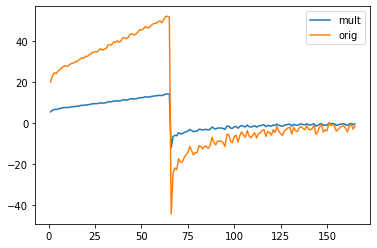

In [163]:
plt.plot((emis_co2_GtC_ds*kgCO2_to_kgC).sel(model = 'NORESM2_A1'), label = 'mult')
plt.plot((emis_co2_GtC_ds).sel(model = 'NORESM2_A1'), label = 'orig')
plt.legend()

emis_co2_GtC_ds*=kgCO2_to_kgC

# Save out CO2 emissions

In [99]:
emis_co2_GtC_ds.to_netcdf('A1B11000gtc_emis_profile_full.nc4')


## Plots

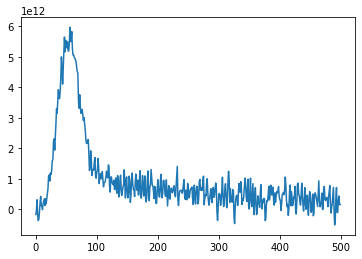

In [26]:
plt.plot(fg_co2_A1B1['GFDL_B1']['val'])

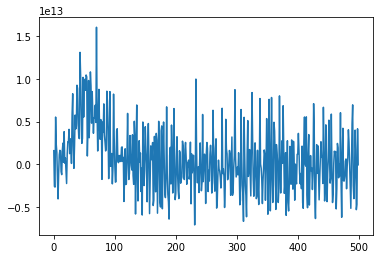

In [27]:
plt.plot(nbp_A1B1['GFDL_B1']['val'])

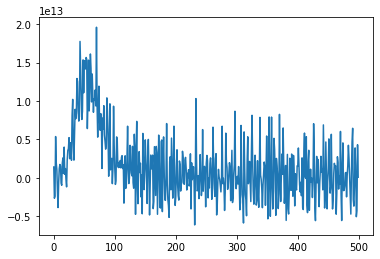

In [28]:
plt.plot(fg_co2_A1B1['GFDL_B1']['val']+nbp_A1B1['GFDL_B1']['val'])


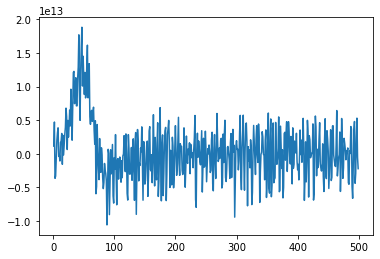

In [41]:
plt.plot((co2_A1B1['GFDL_B1']['val']*7.8e12).diff()*kgCO2_to_kgC)

In [158]:
(co2_A1B1['GFDL_B1']['val'][0]-co2_A1B1['GFDL_B1']['val'][1])*7821e9

-3.310932697433243e+31

In [150]:
test = pd.read_csv('zecmip_data/co2_GFDL-ESM2M_esm-1pct-brch-1000PgC_1861_2360.csv', names = ['year','val'])

In [160]:
(test.loc[0]['val']-test.loc[1]['val'])*7821e12

-2.2316820390542172e+16

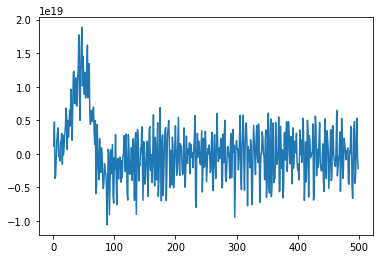

In [161]:
plt.plot(fg_co2_A1B1['GFDL_B1']['val']*1e12+nbp_A1B1['GFDL_B1']['val']*1e12 + co2_A1B1['GFDL_B1']['G_atm'])

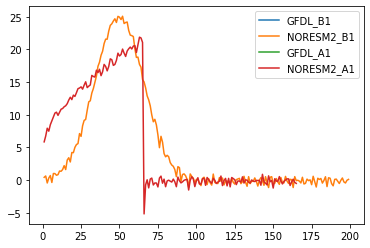

In [26]:
for m in emis_co2_GtC_ds.model.values:
    plt.plot(emis_co2_GtC_ds.sel(model = m), label = m)
    plt.legend()

# Convolution test

## Import G

In [152]:
G_ds = xr.open_dataset('Outputs/G_ds.nc4')['__xarray_dataarray_variable__']
G_mean_ds = xr.open_dataset('Outputs/G_mean_ds.nc4')['__xarray_dataarray_variable__']

G_CDR_ds = xr.open_dataset('Outputs/G_cdr_ds.nc4')['__xarray_dataarray_variable__']
G_CDR_mean_ds = xr.open_dataset('Outputs/G_cdr_mean_ds.nc4')['__xarray_dataarray_variable__']

In [153]:
G_ds = xr.concat([G_ds, -G_CDR_ds], pd.Index(['pulse','cdr'], name = 'pulse_type'))
G_mean_ds = xr.concat([G_mean_ds, -G_CDR_mean_ds], pd.Index(['pulse','cdr'], name = 'pulse_type'))

In [154]:
G_ds.name = 'G[tas]'
G_mean_ds.name = 'G[tas]'

In [155]:
G_ds = G_ds.rename({'year':'s'})
G_mean_ds = G_mean_ds.rename({'year':'s'})

In [156]:
#define our output grid size

ds_out = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-89.5, 90.5, 1.0)),
        "lon": (["lon"], np.arange(0, 360, 1)),
        "lat_b": (["lat_b"], np.arange(-90.,91.,1.0)),
        "lon_b":(["lon_b"], np.arange(.5, 361.5, 1.0))
    }
)

In [157]:
A = utils.find_area(ds_out)

## Convolve

In [164]:
%%time
GF = G_ds.weighted(A).mean(dim = ['lat','lon'])

conv_1pct_mean = {}
for m1 in ['NORESM2_A1', 'NORESM2_B1']:
    conv_1pct_mean[m1] = {}
    for t in ['pulse','cdr']:
        if m1 == 'NORESM2_A1' or m1 == 'NORESM2_B1':
            m2 = 'NORESM2'
        else:
            m2 = m1
        conv_1pct_mean[m1][t] = signal.convolve( np.array(GF.sel(model = m2, pulse_type = t).dropna(dim = 's')), np.array(emis_co2_GtC_ds.sel(model = m1).dropna(dim = 'year')),'full')
        conv_1pct_mean[m1][t] = utils.np_to_xr_mean(conv_1pct_mean[m1][t], GF.sel(model = m2, pulse_type = t), emis_co2_GtC_ds.sel(model = m1))


CPU times: user 1min 45s, sys: 24.5 s, total: 2min 10s
Wall time: 1min 13s


In [165]:
#convert to dataset

conv_1pct_dict = {}
for m in conv_1pct_mean.keys():
    conv_1pct_dict[m] = xr.concat([conv_1pct_mean[m][t] for t in conv_1pct_mean[m].keys()], pd.Index([t for t in conv_1pct_mean[m].keys()], name='pulse_type'))
conv_1pct_mean_ds = xr.concat([conv_1pct_dict[m] for m in conv_1pct_dict.keys()], pd.Index([m for m in conv_1pct_dict.keys()], name='model'), coords='minimal')


In [166]:
tas_A1B1 = {}
for m in model_run_A1B1_dict.keys():
    tas_A1B1[m] = pd.read_csv(f'zecmip_data/fgco2_{model_run_A1B1_dict[m]}', names = ['year','val']) #kgC/m2/s

In [57]:
tas_co2_pictrl = {}

for m in ['NORESM2','GFDL']:
    print(m)
    print('tas')
    tas_co2_pictrl[m] = xr.open_mfdataset(f'cmip6_data/tas_Amon_{model_run_control_dict[m]}',  use_cftime=True) #kg/m2/s
    lat_corners = cfxr.bounds_to_vertices(tas_co2_pictrl[m].isel(time = 0)['lat_bnds'], "bnds", order=None)
    lon_corners = cfxr.bounds_to_vertices(tas_co2_pictrl[m].isel(time = 0)['lon_bnds'], "bnds", order=None)
    tas_co2_pictrl[m] = tas_co2_pictrl[m].assign(lon_b=lon_corners, lat_b=lat_corners)
    tas_co2_pictrl[m] = utils._regrid_ds(tas_co2_pictrl[m], ds_out)

## fix the times so that they line up according to the notes above
m = 'NORESM2'
tas_co2_pictrl[m]['time'] = tas_co2_pictrl[m]['time'] -timedelta(365*1599)

NORESM2
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


GFDL
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


In [64]:
for m1 in ['NORESM2','GFDL']:
    if len(tas_co2_pictrl[m1]['time']) > 3000:  #hack to get the time stamping to work, should find better fix
        periods = 3000
    else:
        periods = len(dif[m1]['time'])
    print(periods) 
    times = pd.date_range('2000', periods=periods, freq='MS')
    weights = times.shift(1, 'MS') - times
    weights = xr.DataArray(weights, [('time', tas_co2_pictrl[m1]['time'][:periods].values)]).astype('float')
    tas_co2_pictrl[m1] =  (tas_co2_pictrl[m1] * weights).groupby('time.year').sum('time')/weights.groupby('time.year').sum('time')

    #dif[m1] = dif[m1].groupby('time.year').mean()
    tas_co2_pictrl[m1]['year'] = range(len(tas_co2_pictrl[m1]['year']))

3000
3000


In [78]:
for m1 in ['NORESM2','GFDL']:
    tas_co2_pictrl[m1] = tas_co2_pictrl[m1].weighted(A).mean(dim = ['lat','lon'])

In [83]:
tas_dif = {}
for m1 in co2_A1B1.keys():
    if m1 == 'GFDL_B1' or m1 == 'GFDL_A1':
        m2 = 'GFDL'
    elif m1 == 'NORESM2_B1' or m1 == 'NORESM2_A1':
        m2 = 'NORESM2'
    print(m1, m2)   
    tas_dif[m1] = xr.Dataset(tas_A1B1[m1].set_index('year'))['val'] - tas_co2_pictrl[m2]['tas']

GFDL_B1 GFDL
NORESM2_B1 NORESM2
GFDL_A1 GFDL
NORESM2_A1 NORESM2


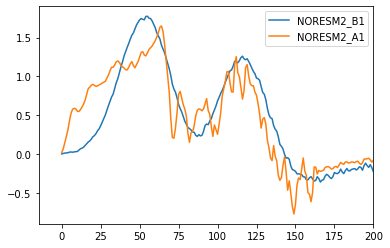

In [167]:
for m in ['NORESM2_B1','NORESM2_A1']:
    plt.plot(conv_1pct_mean_ds.sel(model = m, pulse_type = 'cdr'), label = m)
    plt.legend()
    plt.xlim(None, 200)

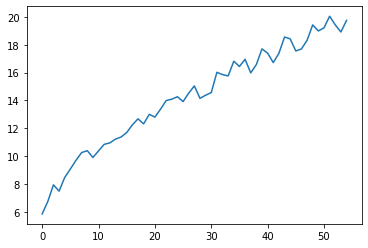

In [120]:
plt.plot(np.array(emis_co2_GtC_ds.sel(model = 'NORESM2_A1').dropna(dim = 'year'))[:55])

In [168]:
test_55 = signal.convolve( np.array(GF.sel(model = 'NORESM2', pulse_type = 'pulse').dropna(dim = 's')), 
                np.array(emis_co2_GtC_ds.sel(model = 'NORESM2_A1').dropna(dim = 'year'))[:55],
                'full')

(-7.65, 55.0)

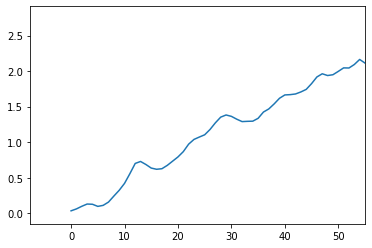

In [169]:
plt.plot(test_55)
plt.xlim(None, 55)

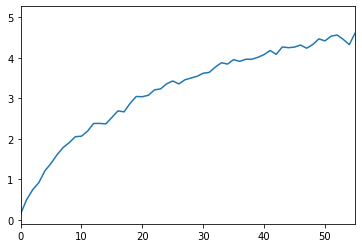

In [170]:
for m in ['NORESM2_A1']:
    plt.plot(tas_A1B1[m]['val'])
    plt.xlim(0,55)

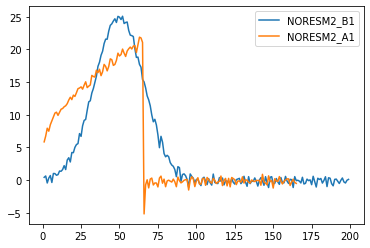

In [111]:
for m in ['NORESM2_B1','NORESM2_A1']:
    plt.plot(emis_co2_GtC_ds.sel(model = m), label = m)
    plt.legend()

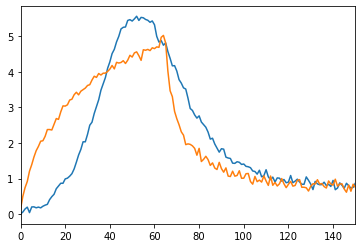

In [96]:
for m in ['NORESM2_B1','NORESM2_A1']:
    plt.plot(tas_A1B1[m]['val'])
    plt.xlim(0,150)

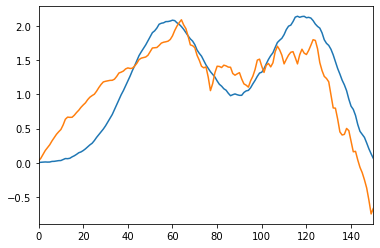

In [171]:
for m in ['NORESM2_B1','NORESM2_A1']:
    plt.plot(conv_1pct_mean_ds.sel(model = m).mean(dim = ['pulse_type']))
    plt.xlim(0,150)